<h1>LSTM</h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100


<h4>Importing Datasets</h4>

In [3]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={
                     'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean = df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID', 'POD_ID', 'ETD_POL_D', 'PARTY_ID',
               'PARTY_NAME', 'POD', 'CNTR_SIZE', 'CNTR_TYPE', 'RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)

    return df_filtered


In [4]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [5]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes


In [6]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))


Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting ports keys</h4>

In [7]:
def getKeyPorts(keybunch):
    keybunch_pouch = []

    # Get a dictionary with key and number of rows for each dataframe in keybunch,
    # but only if the number of rows is greater than 1000
    key_row_counts = {key: len(keybunch[key])
                      for key in keybunch if len(keybunch[key]) > 1000}

    # Sort the keys in descending order of the number of rows
    sorted_keys = sorted(key_row_counts, key=key_row_counts.get, reverse=True)

    for key in sorted_keys:
        row_count = key_row_counts[key]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)

    # Return array of keys
    return keybunch_pouch


print('Old Dataset Keybunch:')
old_df = getKeyPorts(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getKeyPorts(filtered_dataframe2)


Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


<h2>Selection of Key</h2>

In [8]:
# Global selection
sel_country = old_df[0]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 147.1+ KB


In [9]:
# Select features
sel_feat = ['POD', 'RATE']
# make a copy to avoid SettingWithCopyWarning
sel_feat_df = sel_df[sel_feat].copy()


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

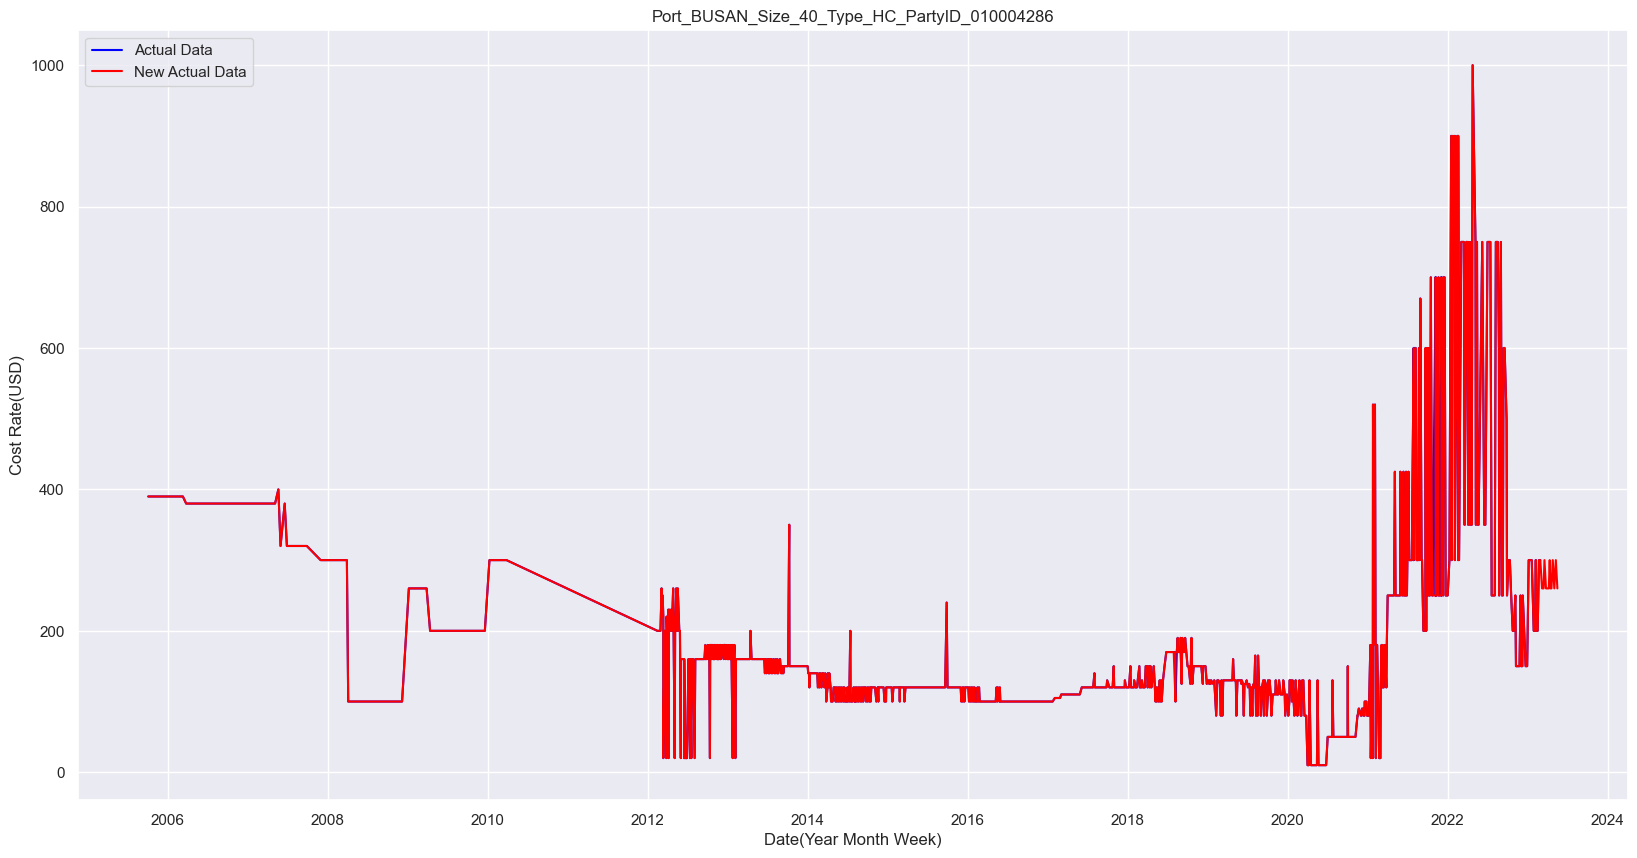

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'],
         color='blue', label="Actual Data")
plt.plot(latest_sel_df['POD'], latest_sel_df['RATE'],
         color='red', label="New Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>Remove Outliers</h4>

(array([ 79.,  79., 257., 476., 246., 147.,  10., 120.,  90.,  10.,  21.,
         60.,   9.,   0.,   2.,   2.,   0.,  15.,   0.,   0.,  12.,   0.,
         46.,   0.,   0.,   0.,   7.,   0.,   0.,   1.]),
 array([  10.,   43.,   76.,  109.,  142.,  175.,  208.,  241.,  274.,
         307.,  340.,  373.,  406.,  439.,  472.,  505.,  538.,  571.,
         604.,  637.,  670.,  703.,  736.,  769.,  802.,  835.,  868.,
         901.,  934.,  967., 1000.]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of RATE')

Text(0.5, 0, 'RATE')

Text(0, 0.5, 'Frequency')

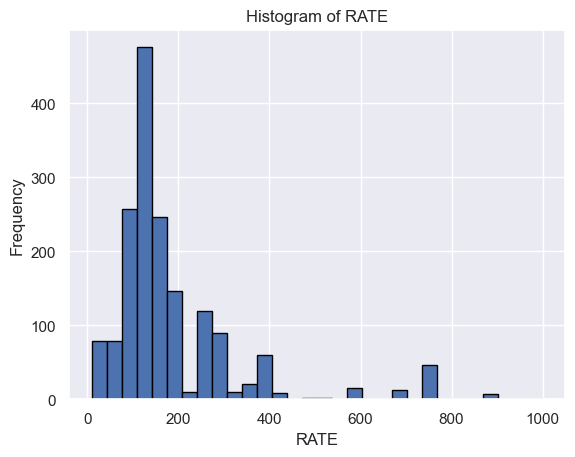

((array([-3.34574786, -3.09144144, -2.95019352, ...,  2.95019352,
          3.09144144,  3.34574786]),
  array([  10.,   10.,   10., ...,  900.,  900., 1000.])),
 (128.44807803687263, 185.65719360568386, 0.8514817671330853))

Text(0.5, 1.0, 'Q-Q plot of RATE')

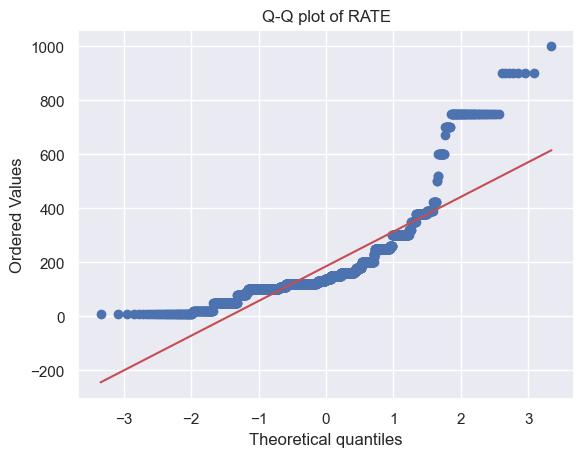

Shapiro-Wilk test:
W: 0.7252808809280396, p-value: 0.0
Anderson-Darling test:
Statistic: 139.16692731944386


Data does not look normal (reject H0)
Performing z-score of 3 to remove outliers... 




,POD,RATE
0,2005-10-03,390.0
1,2005-10-03,390.0
2,2005-10-07,390.0
3,2005-10-07,390.0
4,2005-10-14,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1623 non-null   datetime64[ns]
 1   RATE    1623 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.5 KB


In [11]:
# Histogram
plt.hist(sel_feat_df['RATE'], bins=30, edgecolor='black')
plt.title("Histogram of RATE")
plt.xlabel("RATE")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(sel_feat_df['RATE'], plot=plt)
plt.title("Q-Q plot of RATE")
plt.show()

# Shapiro-Wilk test
print("Shapiro-Wilk test:")
W, p = stats.shapiro(sel_feat_df['RATE'])
print(f"W: {W}, p-value: {p}")

# Anderson-Darling test
print("Anderson-Darling test:")
result = stats.anderson(sel_feat_df['RATE'])
print(f"Statistic: {result.statistic}")
# using a 5% significance level
if result.statistic < result.critical_values[2]:
    print("\n======================================")
    print("\nData looks normal (fail to reject H0)")
    print("Performing Interquartile Range (IQR) to remove outliers...")
    print("======================================\n")

    # IQR
    Q1 = sel_feat_df['RATE'].quantile(0.25)
    Q3 = sel_feat_df['RATE'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    sel_feat_df = sel_feat_df[(sel_feat_df['RATE'] >= lower_bound) & (
        sel_feat_df['RATE'] <= upper_bound)]

else:
    print("\n======================================")
    print("\nData does not look normal (reject H0)")
    print("Performing z-score of 3 to remove outliers... \n")
    print("======================================\n")

    # z-score
    z_scores = stats.zscore(sel_feat_df['RATE'])
    threshold = 3  # Z-score threshold for outlier detection

    # Remove outliers
    robust_df = sel_feat_df[(np.abs(z_scores) < threshold)]

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()


<h4>Interpolate missing values in between dates</h4>

In [12]:
# Interpolate missing values

# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(
    subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with
# a date range from min to max date dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(
    start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one.
# Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')

# Perform interpolation polynomial
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(
    method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()


,POD,RATE
0,2005-10-03,390.0
1,2005-10-04,390.0
2,2005-10-05,390.0
3,2005-10-06,390.0
4,2005-10-07,390.0


,POD,RATE
6366,2023-02-24,300.0
6367,2023-02-25,300.0
6368,2023-02-26,300.0
6369,2023-02-27,300.0
6370,2023-02-28,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6371 entries, 0 to 6370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6371 non-null   datetime64[ns]
 1   RATE    6371 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.3 KB


<h4>Grouping it to week</h4>

In [13]:
# Group Weekly

# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - \
    pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(
), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - \
    pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with the dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated,
                     on=['YearMonthWeek'], how='left')

# group by YearMonthWeek and compute rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Handle summed values with skewness
    if abs(rate_skew) > 0.5:
        rate_metric = group_df['RATE'].median()
    else:
        rate_metric = group_df['RATE'].mean()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2057257721.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2057257721.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2057257721.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2057257721.py:48: FutureWarning: The frame.append method is deprecated and will be r

,YearMonthWeek,Rate
0,2005-10-03,390.0
1,2005-10-10,390.0
2,2005-10-17,390.0
3,2005-10-24,390.0
4,2005-10-31,390.0
5,2005-11-07,390.0
6,2005-11-14,390.0
7,2005-11-21,390.0
8,2005-11-28,390.0
9,2005-12-05,390.0


,YearMonthWeek,Rate
893,2022-11-14,150.00
894,2022-11-21,150.00
895,2022-11-28,191.43
896,2022-12-05,150.00
897,2022-12-12,211.54
898,2022-12-19,157.69
899,2022-12-26,150.00
900,2023-01-02,278.57
901,2023-01-09,300.00
902,2023-01-16,300.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  908 non-null    datetime64[ns]
 1   Rate           908 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

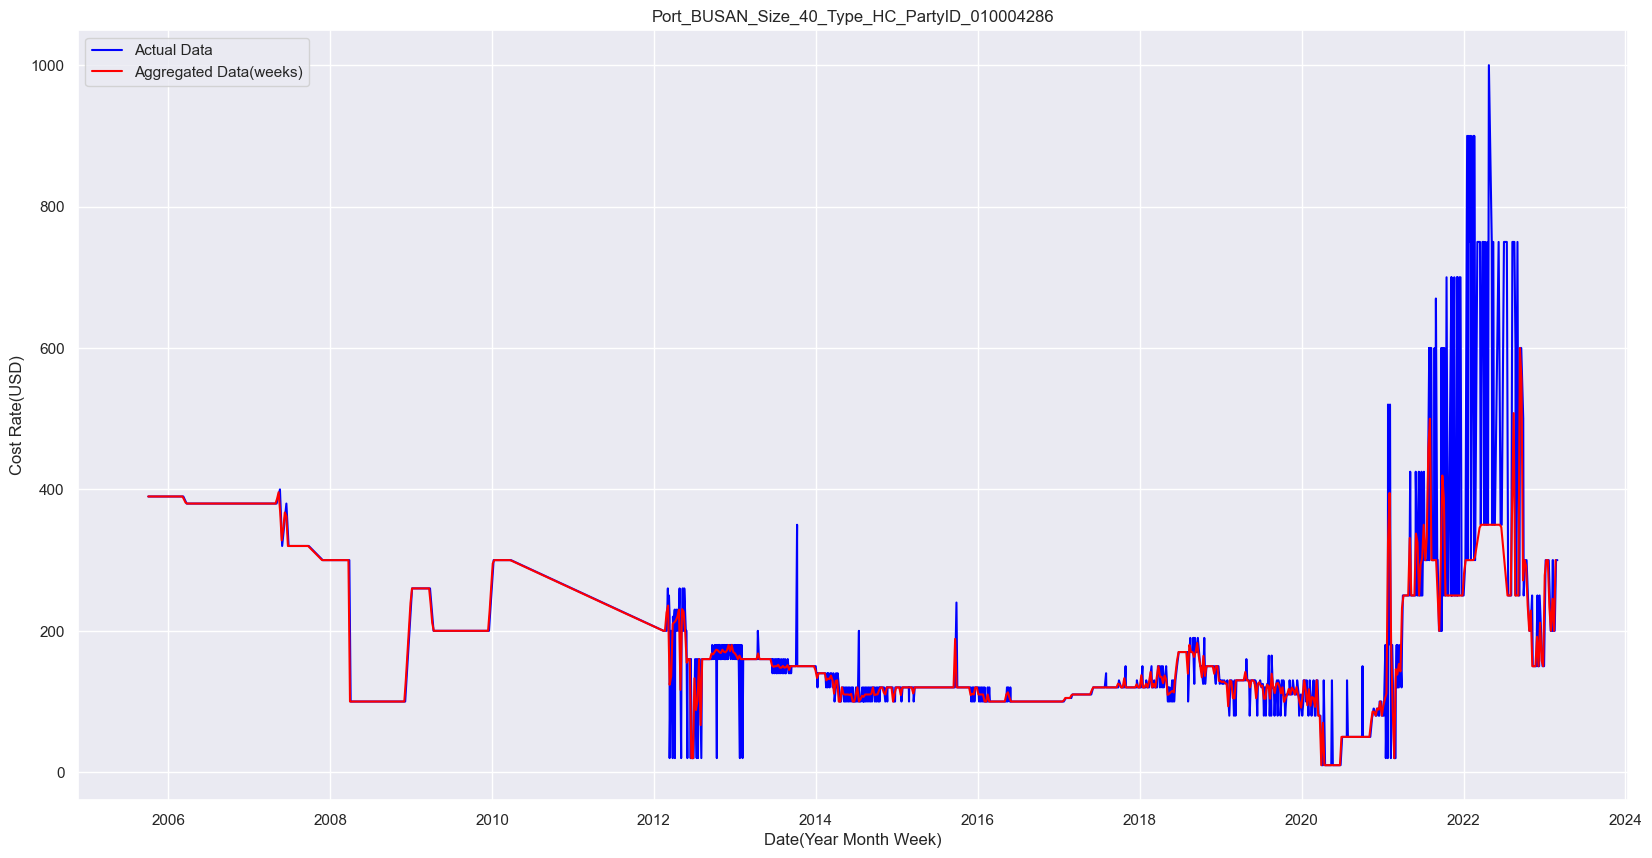

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'],
         color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [15]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest
# dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD']
                             > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


<h4>BI-LSTM Regression<h4>

In [16]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()

    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, input_shape=(look_back, trainX.shape[2]),
                           activation='tanh', recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(
                LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(0.01)))
        else:
            # Middle layers return sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, activation='tanh',
                           recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.0005))

    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2,
                        validation_data=(testX, testY), callbacks=[es])
    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()


Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
5/5 - 26s - loss: 3.7691 - val_loss: 3.6628 - 26s/epoch - 5s/step
Epoch 2/50
5/5 - 0s - loss: 3.6264 - val_loss: 3.5231 - 274ms/epoch - 55ms/step
Epoch 3/50
5/5 - 0s - loss: 3.4881 - val_loss: 3.3880 - 275ms/epoch - 55ms/step
Epoch 4/50
5/5 - 0s - loss: 3.3546 - val_loss: 3.2576 - 273ms/epoch - 55ms/step
Epoch 5/50
5/5 - 0s - loss: 3.2257 - val_loss: 3.1320 - 268ms/epoch - 54ms/step
Epoch 6/50
5/5 - 0s - loss: 3.1013 - val_loss: 3.0111 - 263ms/epoch - 53ms/step
Epoch 7/50
5/5 - 0s - loss: 2.9820 - val_loss: 2.8948 - 251ms/epoch - 50ms/step
Epoch 8/50
5/5 - 0s - loss: 2.8671 - val_loss: 2.7831 - 248ms/epoch - 50ms/step
Epoch 9/50
5/5 - 0s - loss: 2.7566 - val_loss: 2.6757 - 249ms/epoch - 50ms/step
Epoch 10/50
5/5 - 0s - loss: 2.6510 - val_loss: 2.5727 - 244ms/epoch - 49ms/step
Epoch 11/50
5/5 - 0s - loss: 2.5486 - val_loss: 2.4737 - 239ms/epoch - 48ms/step
Epoch 12/50
5/5 - 0s - lo

9/9 [==============================] - 0s 6ms/step
Train Score: 100.75 RMSE for 50 epochs
Test Score: 107.32 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
5/5 - 22s - loss: 1.9190 - val_loss: 1.8677 - 22s/epoch - 4s/step
Epoch 2/50
5/5 - 0s - loss: 1.8660 - val_loss: 1.8160 - 190ms/epoch - 38ms/step
Epoch 3/50
5/5 - 0s - loss: 1.8144 - val_loss: 1.7654 - 185ms/epoch - 37ms/step
Epoch 4/50
5/5 - 0s - loss: 1.7638 - val_loss: 1.7161 - 184ms/epoch - 37ms/step
Epoch 5/50
5/5 - 0s - loss: 1.7143 - val_loss: 1.6681 - 176ms/epoch - 35ms/step
Epoch 6/50
5/5 - 0s - loss: 1.6663 - val_loss: 1.6213 - 174ms/epoch - 35ms/step
Epoch 7/50
5/5 - 0s - loss: 1.6200 - val_loss: 1.5759 - 173ms/epoch - 35ms/step
Epoch 8/50
5/5 - 0s - loss: 1.5742 - val_loss: 1.5317 - 172ms/epoch - 34ms/step
Epoch 9/50
5/5 - 0s - loss: 1.5299 - val_loss: 1.4887 - 173ms/epoch - 35ms/step
Epoch 10/50
5/5 - 0s - loss: 1.4880 - val_loss: 1.4469 - 176ms/epoch - 35ms/step
Epoch 11/50


9/9 [==============================] - 0s 5ms/step
Train Score: 103.91 RMSE for 50 epochs
Test Score: 107.99 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
5/5 - 17s - loss: 0.9868 - val_loss: 0.9547 - 17s/epoch - 3s/step
Epoch 2/50
5/5 - 0s - loss: 0.9652 - val_loss: 0.9339 - 145ms/epoch - 29ms/step
Epoch 3/50
5/5 - 0s - loss: 0.9441 - val_loss: 0.9135 - 142ms/epoch - 28ms/step
Epoch 4/50
5/5 - 0s - loss: 0.9233 - val_loss: 0.8934 - 142ms/epoch - 28ms/step
Epoch 5/50
5/5 - 0s - loss: 0.9025 - val_loss: 0.8736 - 141ms/epoch - 28ms/step
Epoch 6/50
5/5 - 0s - loss: 0.8824 - val_loss: 0.8543 - 136ms/epoch - 27ms/step
Epoch 7/50
5/5 - 0s - loss: 0.8629 - val_loss: 0.8353 - 138ms/epoch - 28ms/step
Epoch 8/50
5/5 - 0s - loss: 0.8434 - val_loss: 0.8167 - 137ms/epoch - 27ms/step
Epoch 9/50
5/5 - 0s - loss: 0.8248 - val_loss: 0.7984 - 135ms/epoch - 27ms/step
Epoch 10/50
5/5 - 0s - loss: 0.8057 - val_loss: 0.7805 - 136ms/epoch - 27ms/step
Epoch 11/50
5/5 - 0s

9/9 [==============================] - 0s 4ms/step
Train Score: 98.99 RMSE for 50 epochs
Test Score: 107.47 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/50
5/5 - 13s - loss: 0.5251 - val_loss: 0.5001 - 13s/epoch - 3s/step
Epoch 2/50
5/5 - 0s - loss: 0.5151 - val_loss: 0.4908 - 111ms/epoch - 22ms/step
Epoch 3/50
5/5 - 0s - loss: 0.5054 - val_loss: 0.4816 - 110ms/epoch - 22ms/step
Epoch 4/50
5/5 - 0s - loss: 0.4957 - val_loss: 0.4725 - 111ms/epoch - 22ms/step
Epoch 5/50
5/5 - 0s - loss: 0.4865 - val_loss: 0.4636 - 107ms/epoch - 21ms/step
Epoch 6/50
5/5 - 0s - loss: 0.4769 - val_loss: 0.4548 - 108ms/epoch - 22ms/step
Epoch 7/50
5/5 - 0s - loss: 0.4675 - val_loss: 0.4461 - 112ms/epoch - 22ms/step
Epoch 8/50
5/5 - 0s - loss: 0.4585 - val_loss: 0.4375 - 108ms/epoch - 22ms/step
Epoch 9/50
5/5 - 0s - loss: 0.4490 - val_loss: 0.4290 - 108ms/epoch - 22ms/step
Epoch 10/50
5/5 - 0s - loss: 0.4399 - val_loss: 0.4207 - 106ms/epoch - 21ms/step
Epoch 11/50
5/5 - 0s - loss: 

9/9 [==============================] - 0s 3ms/step
Train Score: 99.97 RMSE for 50 epochs
Test Score: 107.30 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/50
5/5 - 9s - loss: 0.3185 - val_loss: 0.2957 - 9s/epoch - 2s/step
Epoch 2/50
5/5 - 0s - loss: 0.3127 - val_loss: 0.2906 - 85ms/epoch - 17ms/step
Epoch 3/50
5/5 - 0s - loss: 0.3072 - val_loss: 0.2856 - 85ms/epoch - 17ms/step
Epoch 4/50
5/5 - 0s - loss: 0.3019 - val_loss: 0.2807 - 83ms/epoch - 17ms/step
Epoch 5/50
5/5 - 0s - loss: 0.2965 - val_loss: 0.2758 - 107ms/epoch - 21ms/step
Epoch 6/50
5/5 - 0s - loss: 0.2912 - val_loss: 0.2710 - 84ms/epoch - 17ms/step
Epoch 7/50
5/5 - 0s - loss: 0.2857 - val_loss: 0.2663 - 83ms/epoch - 17ms/step
Epoch 8/50
5/5 - 0s - loss: 0.2808 - val_loss: 0.2616 - 82ms/epoch - 16ms/step
Epoch 9/50
5/5 - 0s - loss: 0.2758 - val_loss: 0.2570 - 82ms/epoch - 16ms/step
Epoch 10/50
5/5 - 0s - loss: 0.2707 - val_loss: 0.2525 - 82ms/epoch - 16ms/step
Epoch 11/50
5/5 - 0s - loss: 0.2661 - val_los

9/9 [==============================] - 0s 2ms/step
Train Score: 101.33 RMSE for 50 epochs
Test Score: 107.37 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Epoch 1/50
5/5 - 4s - loss: 0.0937 - val_loss: 0.0816 - 4s/epoch - 852ms/step
Epoch 2/50
5/5 - 0s - loss: 0.0871 - val_loss: 0.0783 - 59ms/epoch - 12ms/step
Epoch 3/50
5/5 - 0s - loss: 0.0807 - val_loss: 0.0755 - 58ms/epoch - 12ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0827 - val_loss: 0.0730 - 58ms/epoch - 12ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0816 - val_loss: 0.0710 - 56ms/epoch - 11ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0781 - val_loss: 0.0694 - 56ms/epoch - 11ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0753 - val_loss: 0.0681 - 56ms/epoch - 11ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0762 - val_loss: 0.0670 - 57ms/epoch - 11ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0772 - val_loss: 0.0662 - 56ms/epoch - 11ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0721 - val_loss: 0.0655 - 59ms/epoch - 12ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0759 - val_loss: 

9/9 [==============================] - 0s 2ms/step
Train Score: 48.37 RMSE for 50 epochs
Test Score: 63.73 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
5/5 - 26s - loss: 3.7529 - val_loss: 3.6456 - 26s/epoch - 5s/step
Epoch 2/100
5/5 - 0s - loss: 3.6080 - val_loss: 3.5044 - 243ms/epoch - 49ms/step
Epoch 3/100
5/5 - 0s - loss: 3.4677 - val_loss: 3.3679 - 244ms/epoch - 49ms/step
Epoch 4/100
5/5 - 0s - loss: 3.3326 - val_loss: 3.2361 - 240ms/epoch - 48ms/step
Epoch 5/100
5/5 - 0s - loss: 3.2022 - val_loss: 3.1093 - 240ms/epoch - 48ms/step
Epoch 6/100
5/5 - 0s - loss: 3.0767 - val_loss: 2.9873 - 235ms/epoch - 47ms/step
Epoch 7/100
5/5 - 0s - loss: 2.9559 - val_loss: 2.8700 - 239ms/epoch - 48ms/step
Epoch 8/100
5/5 - 0s - loss: 2.8394 - val_loss: 2.7574 - 234ms/epoch - 47ms/step
Epoch 9/100
5/5 - 0s - loss: 2.7290 - val_loss: 2.6494 - 233ms/epoch - 47ms/step
Epoch 10/100
5/5 - 0s - loss: 2.6213 - val_loss: 2.

9/9 [==============================] - 0s 6ms/step
Train Score: 98.36 RMSE for 100 epochs
Test Score: 107.75 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
5/5 - 21s - loss: 1.9450 - val_loss: 1.8935 - 21s/epoch - 4s/step
Epoch 2/100
5/5 - 0s - loss: 1.8918 - val_loss: 1.8413 - 181ms/epoch - 36ms/step
Epoch 3/100
5/5 - 0s - loss: 1.8396 - val_loss: 1.7904 - 186ms/epoch - 37ms/step
Epoch 4/100
5/5 - 0s - loss: 1.7888 - val_loss: 1.7407 - 185ms/epoch - 37ms/step
Epoch 5/100
5/5 - 0s - loss: 1.7392 - val_loss: 1.6922 - 188ms/epoch - 38ms/step
Epoch 6/100
5/5 - 0s - loss: 1.6912 - val_loss: 1.6451 - 175ms/epoch - 35ms/step
Epoch 7/100
5/5 - 0s - loss: 1.6441 - val_loss: 1.5992 - 173ms/epoch - 35ms/step
Epoch 8/100
5/5 - 0s - loss: 1.5982 - val_loss: 1.5545 - 170ms/epoch - 34ms/step
Epoch 9/100
5/5 - 0s - loss: 1.5533 - val_loss: 1.5110 - 171ms/epoch - 34ms/step
Epoch 10/100
5/5 - 0s - loss: 1.5102 - val_loss: 1.4687 - 173ms/epoch - 35ms/step
E

9/9 [==============================] - 0s 5ms/step
Train Score: 99.11 RMSE for 100 epochs
Test Score: 107.44 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
5/5 - 18s - loss: 1.0246 - val_loss: 0.9902 - 18s/epoch - 4s/step
Epoch 2/100
5/5 - 0s - loss: 0.9987 - val_loss: 0.9654 - 151ms/epoch - 30ms/step
Epoch 3/100
5/5 - 0s - loss: 0.9729 - val_loss: 0.9412 - 146ms/epoch - 29ms/step
Epoch 4/100
5/5 - 0s - loss: 0.9475 - val_loss: 0.9176 - 142ms/epoch - 28ms/step
Epoch 5/100
5/5 - 0s - loss: 0.9227 - val_loss: 0.8946 - 143ms/epoch - 29ms/step
Epoch 6/100
5/5 - 0s - loss: 0.8995 - val_loss: 0.8723 - 138ms/epoch - 28ms/step
Epoch 7/100
5/5 - 0s - loss: 0.8773 - val_loss: 0.8508 - 138ms/epoch - 28ms/step
Epoch 8/100
5/5 - 0s - loss: 0.8555 - val_loss: 0.8300 - 138ms/epoch - 28ms/step
Epoch 9/100
5/5 - 0s - loss: 0.8352 - val_loss: 0.8099 - 138ms/epoch - 28ms/step
Epoch 10/100
5/5 - 0s - loss: 0.8144 - val_loss: 0.7905 - 139ms/epoch - 28ms/step
Epoch 11/

9/9 [==============================] - 0s 3ms/step
Train Score: 98.31 RMSE for 100 epochs
Test Score: 107.78 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/100
5/5 - 12s - loss: 0.5299 - val_loss: 0.5047 - 12s/epoch - 2s/step
Epoch 2/100
5/5 - 0s - loss: 0.5195 - val_loss: 0.4951 - 114ms/epoch - 23ms/step
Epoch 3/100
5/5 - 0s - loss: 0.5094 - val_loss: 0.4855 - 112ms/epoch - 22ms/step
Epoch 4/100
5/5 - 0s - loss: 0.4994 - val_loss: 0.4761 - 113ms/epoch - 23ms/step
Epoch 5/100
5/5 - 0s - loss: 0.4893 - val_loss: 0.4669 - 108ms/epoch - 22ms/step
Epoch 6/100
5/5 - 0s - loss: 0.4799 - val_loss: 0.4578 - 108ms/epoch - 22ms/step
Epoch 7/100
5/5 - 0s - loss: 0.4700 - val_loss: 0.4489 - 108ms/epoch - 22ms/step
Epoch 8/100
5/5 - 0s - loss: 0.4609 - val_loss: 0.4401 - 112ms/epoch - 22ms/step
Epoch 9/100
5/5 - 0s - loss: 0.4511 - val_loss: 0.4315 - 108ms/epoch - 22ms/step
Epoch 10/100
5/5 - 0s - loss: 0.4424 - val_loss: 0.4230 - 108ms/epoch - 22ms/step
Epoch 11/100
5/5 

9/9 [==============================] - 0s 3ms/step
Train Score: 98.27 RMSE for 100 epochs
Test Score: 107.81 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/100
5/5 - 10s - loss: 0.3083 - val_loss: 0.2841 - 10s/epoch - 2s/step
Epoch 2/100
5/5 - 0s - loss: 0.3004 - val_loss: 0.2772 - 87ms/epoch - 17ms/step
Epoch 3/100
5/5 - 0s - loss: 0.2928 - val_loss: 0.2704 - 90ms/epoch - 18ms/step
Epoch 4/100
5/5 - 0s - loss: 0.2856 - val_loss: 0.2639 - 86ms/epoch - 17ms/step
Epoch 5/100
5/5 - 0s - loss: 0.2778 - val_loss: 0.2575 - 83ms/epoch - 17ms/step
Epoch 6/100
5/5 - 0s - loss: 0.2711 - val_loss: 0.2512 - 85ms/epoch - 17ms/step
Epoch 7/100
5/5 - 0s - loss: 0.2640 - val_loss: 0.2451 - 86ms/epoch - 17ms/step
Epoch 8/100
5/5 - 0s - loss: 0.2579 - val_loss: 0.2391 - 89ms/epoch - 18ms/step
Epoch 9/100
5/5 - 0s - loss: 0.2504 - val_loss: 0.2334 - 94ms/epoch - 19ms/step
Epoch 10/100
5/5 - 0s - loss: 0.2442 - val_loss: 0.2277 - 88ms/epoch - 18ms/step
Epoch 11/100
5/5 - 0s - loss: 0.

9/9 [==============================] - 0s 3ms/step
Train Score: 98.60 RMSE for 100 epochs
Test Score: 107.79 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Epoch 1/100
5/5 - 4s - loss: 0.2059 - val_loss: 0.1803 - 4s/epoch - 864ms/step
Epoch 2/100
5/5 - 0s - loss: 0.2021 - val_loss: 0.1763 - 57ms/epoch - 11ms/step
Epoch 3/100
5/5 - 0s - loss: 0.1951 - val_loss: 0.1725 - 56ms/epoch - 11ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1921 - val_loss: 0.1687 - 56ms/epoch - 11ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1873 - val_loss: 0.1651 - 58ms/epoch - 12ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1826 - val_loss: 0.1615 - 57ms/epoch - 11ms/step
Epoch 7/100
5/5 - 0s - loss: 0.1783 - val_loss: 0.1580 - 55ms/epoch - 11ms/step
Epoch 8/100
5/5 - 0s - loss: 0.1755 - val_loss: 0.1546 - 57ms/epoch - 11ms/step
Epoch 9/100
5/5 - 0s - loss: 0.1711 - val_loss: 0.1513 - 56ms/epoch - 11ms/step
Epoch 10/100
5/5 - 0s - loss: 0.1679 - val_loss: 0.1480 - 55ms/epoch - 11ms/step
Epoch 11/100
5/5 - 0s - loss: 0.1632 

9/9 [==============================] - 0s 2ms/step
Train Score: 90.73 RMSE for 100 epochs
Test Score: 100.57 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/150
5/5 - 26s - loss: 3.7459 - val_loss: 3.6395 - 26s/epoch - 5s/step
Epoch 2/150
5/5 - 0s - loss: 3.6030 - val_loss: 3.4998 - 246ms/epoch - 49ms/step
Epoch 3/150
5/5 - 0s - loss: 3.4647 - val_loss: 3.3648 - 246ms/epoch - 49ms/step
Epoch 4/150
5/5 - 0s - loss: 3.3309 - val_loss: 3.2344 - 240ms/epoch - 48ms/step
Epoch 5/150
5/5 - 0s - loss: 3.2018 - val_loss: 3.1088 - 245ms/epoch - 49ms/step
Epoch 6/150
5/5 - 0s - loss: 3.0773 - val_loss: 2.9879 - 236ms/epoch - 47ms/step
Epoch 7/150
5/5 - 0s - loss: 2.9581 - val_loss: 2.8717 - 241ms/epoch - 48ms/step
Epoch 8/150
5/5 - 0s - loss: 2.8431 - val_loss: 2.7601 - 238ms/epoch - 48ms/step
Epoch 9/150
5/5 - 0s - loss: 2.7333 - val_loss: 2.6528 - 233ms/epoch - 47ms/step
Epoch 10/150
5/5 - 0s - loss: 2.6260 - val_loss:

9/9 [==============================] - 0s 6ms/step
Train Score: 98.03 RMSE for 150 epochs
Test Score: 107.99 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/150
5/5 - 22s - loss: 1.9325 - val_loss: 1.8807 - 22s/epoch - 4s/step
Epoch 2/150
5/5 - 0s - loss: 1.8787 - val_loss: 1.8279 - 180ms/epoch - 36ms/step
Epoch 3/150
5/5 - 0s - loss: 1.8257 - val_loss: 1.7764 - 183ms/epoch - 37ms/step
Epoch 4/150
5/5 - 0s - loss: 1.7741 - val_loss: 1.7261 - 184ms/epoch - 37ms/step
Epoch 5/150
5/5 - 0s - loss: 1.7239 - val_loss: 1.6770 - 174ms/epoch - 35ms/step
Epoch 6/150
5/5 - 0s - loss: 1.6750 - val_loss: 1.6293 - 175ms/epoch - 35ms/step
Epoch 7/150
5/5 - 0s - loss: 1.6267 - val_loss: 1.5828 - 174ms/epoch - 35ms/step
Epoch 8/150
5/5 - 0s - loss: 1.5806 - val_loss: 1.5376 - 172ms/epoch - 34ms/step
Epoch 9/150
5/5 - 0s - loss: 1.5350 - val_loss: 1.4936 - 181ms/epoch - 36ms/step
Epoch 10/150
5/5 - 0s - loss: 1.4908 - val_loss: 1.4508 - 179ms/epoch - 36ms/step
E

9/9 [==============================] - 0s 5ms/step
Train Score: 98.00 RMSE for 150 epochs
Test Score: 108.02 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/150
5/5 - 18s - loss: 0.9981 - val_loss: 0.9657 - 18s/epoch - 4s/step
Epoch 2/150
5/5 - 0s - loss: 0.9758 - val_loss: 0.9442 - 144ms/epoch - 29ms/step
Epoch 3/150
5/5 - 0s - loss: 0.9540 - val_loss: 0.9232 - 144ms/epoch - 29ms/step
Epoch 4/150
5/5 - 0s - loss: 0.9325 - val_loss: 0.9025 - 144ms/epoch - 29ms/step
Epoch 5/150
5/5 - 0s - loss: 0.9109 - val_loss: 0.8822 - 138ms/epoch - 28ms/step
Epoch 6/150
5/5 - 0s - loss: 0.8904 - val_loss: 0.8623 - 138ms/epoch - 28ms/step
Epoch 7/150
5/5 - 0s - loss: 0.8703 - val_loss: 0.8428 - 141ms/epoch - 28ms/step
Epoch 8/150
5/5 - 0s - loss: 0.8506 - val_loss: 0.8237 - 137ms/epoch - 27ms/step
Epoch 9/150
5/5 - 0s - loss: 0.8305 - val_loss: 0.8050 - 136ms/epoch - 27ms/step
Epoch 10/150
5/5 - 0s - loss: 0.8119 - val_loss: 0.7867 - 137ms/epoch - 27ms/step
Epoch 11/

9/9 [==============================] - 0s 4ms/step
Train Score: 98.05 RMSE for 150 epochs
Test Score: 107.97 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/150
5/5 - 13s - loss: 0.5530 - val_loss: 0.5278 - 13s/epoch - 3s/step
Epoch 2/150
5/5 - 0s - loss: 0.5425 - val_loss: 0.5179 - 119ms/epoch - 24ms/step
Epoch 3/150
5/5 - 0s - loss: 0.5322 - val_loss: 0.5081 - 114ms/epoch - 23ms/step
Epoch 4/150
5/5 - 0s - loss: 0.5221 - val_loss: 0.4985 - 113ms/epoch - 23ms/step
Epoch 5/150
5/5 - 0s - loss: 0.5123 - val_loss: 0.4890 - 111ms/epoch - 22ms/step
Epoch 6/150
5/5 - 0s - loss: 0.5020 - val_loss: 0.4798 - 107ms/epoch - 21ms/step
Epoch 7/150
5/5 - 0s - loss: 0.4919 - val_loss: 0.4706 - 107ms/epoch - 21ms/step
Epoch 8/150
5/5 - 0s - loss: 0.4831 - val_loss: 0.4616 - 106ms/epoch - 21ms/step
Epoch 9/150
5/5 - 0s - loss: 0.4722 - val_loss: 0.4527 - 110ms/epoch - 22ms/step
Epoch 10/150
5/5 - 0s - loss: 0.4642 - val_loss: 0.4440 - 109ms/epoch - 22ms/step
Epoch 11/150
5/5 

9/9 [==============================] - 0s 4ms/step
Train Score: 98.00 RMSE for 150 epochs
Test Score: 108.02 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/150
5/5 - 10s - loss: 0.3139 - val_loss: 0.2911 - 10s/epoch - 2s/step
Epoch 2/150
5/5 - 0s - loss: 0.3089 - val_loss: 0.2865 - 84ms/epoch - 17ms/step
Epoch 3/150
5/5 - 0s - loss: 0.3037 - val_loss: 0.2820 - 83ms/epoch - 17ms/step
Epoch 4/150
5/5 - 0s - loss: 0.2990 - val_loss: 0.2776 - 83ms/epoch - 17ms/step
Epoch 5/150
5/5 - 0s - loss: 0.2943 - val_loss: 0.2733 - 80ms/epoch - 16ms/step
Epoch 6/150
5/5 - 0s - loss: 0.2895 - val_loss: 0.2690 - 82ms/epoch - 16ms/step
Epoch 7/150
5/5 - 0s - loss: 0.2849 - val_loss: 0.2648 - 84ms/epoch - 17ms/step
Epoch 8/150
5/5 - 0s - loss: 0.2805 - val_loss: 0.2607 - 79ms/epoch - 16ms/step
Epoch 9/150
5/5 - 0s - loss: 0.2761 - val_loss: 0.2566 - 80ms/epoch - 16ms/step
Epoch 10/150
5/5 - 0s - loss: 0.2715 - val_loss: 0.2526 - 79ms/epoch - 16ms/step
Epoch 11/150
5/5 - 0s - loss: 0.

9/9 [==============================] - 0s 2ms/step
Train Score: 97.87 RMSE for 150 epochs
Test Score: 108.16 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Epoch 1/150
5/5 - 4s - loss: 0.1490 - val_loss: 0.1328 - 4s/epoch - 890ms/step
Epoch 2/150
5/5 - 0s - loss: 0.1472 - val_loss: 0.1297 - 57ms/epoch - 11ms/step
Epoch 3/150
5/5 - 0s - loss: 0.1424 - val_loss: 0.1267 - 56ms/epoch - 11ms/step
Epoch 4/150
5/5 - 0s - loss: 0.1409 - val_loss: 0.1238 - 57ms/epoch - 11ms/step
Epoch 5/150
5/5 - 0s - loss: 0.1366 - val_loss: 0.1209 - 61ms/epoch - 12ms/step
Epoch 6/150
5/5 - 0s - loss: 0.1335 - val_loss: 0.1180 - 58ms/epoch - 12ms/step
Epoch 7/150
5/5 - 0s - loss: 0.1297 - val_loss: 0.1152 - 60ms/epoch - 12ms/step
Epoch 8/150
5/5 - 0s - loss: 0.1267 - val_loss: 0.1124 - 61ms/epoch - 12ms/step
Epoch 9/150
5/5 - 0s - loss: 0.1235 - val_loss: 0.1098 - 63ms/epoch - 13ms/step
Epoch 10/150
5/5 - 0s - loss: 0.1192 - val_loss: 0.1071 - 58ms/epoch - 12ms/step
Epoch 11/150
5/5 - 0s - loss: 0.1176 

9/9 [==============================] - 0s 2ms/step
Train Score: 70.80 RMSE for 150 epochs
Test Score: 83.21 RMSE for 150 epochs
Training for 300 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/300
5/5 - 28s - loss: 3.7569 - val_loss: 3.6510 - 28s/epoch - 6s/step
Epoch 2/300
5/5 - 0s - loss: 3.6150 - val_loss: 3.5120 - 261ms/epoch - 52ms/step
Epoch 3/300
5/5 - 0s - loss: 3.4775 - val_loss: 3.3776 - 257ms/epoch - 51ms/step
Epoch 4/300
5/5 - 0s - loss: 3.3448 - val_loss: 3.2479 - 256ms/epoch - 51ms/step
Epoch 5/300
5/5 - 0s - loss: 3.2167 - val_loss: 3.1230 - 245ms/epoch - 49ms/step
Epoch 6/300
5/5 - 0s - loss: 3.0933 - val_loss: 3.0027 - 244ms/epoch - 49ms/step
Epoch 7/300
5/5 - 0s - loss: 2.9746 - val_loss: 2.8871 - 237ms/epoch - 47ms/step
Epoch 8/300
5/5 - 0s - loss: 2.8605 - val_loss: 2.7761 - 272ms/epoch - 54ms/step
Epoch 9/300
5/5 - 0s - loss: 2.7511 - val_loss: 2.6694 - 280ms/epoch - 56ms/step
Epoch 10/300
5/5 - 0s - loss: 2.6456 - val_loss: 

9/9 [==============================] - 0s 5ms/step
Train Score: 97.45 RMSE for 300 epochs
Test Score: 108.84 RMSE for 300 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/300
5/5 - 22s - loss: 1.9092 - val_loss: 1.8574 - 22s/epoch - 4s/step
Epoch 2/300
5/5 - 0s - loss: 1.8553 - val_loss: 1.8047 - 194ms/epoch - 39ms/step
Epoch 3/300
5/5 - 0s - loss: 1.8024 - val_loss: 1.7533 - 184ms/epoch - 37ms/step
Epoch 4/300
5/5 - 0s - loss: 1.7506 - val_loss: 1.7031 - 182ms/epoch - 36ms/step
Epoch 5/300
5/5 - 0s - loss: 1.7002 - val_loss: 1.6542 - 176ms/epoch - 35ms/step
Epoch 6/300
5/5 - 0s - loss: 1.6517 - val_loss: 1.6067 - 175ms/epoch - 35ms/step
Epoch 7/300
5/5 - 0s - loss: 1.6040 - val_loss: 1.5605 - 174ms/epoch - 35ms/step
Epoch 8/300
5/5 - 0s - loss: 1.5581 - val_loss: 1.5155 - 173ms/epoch - 35ms/step
Epoch 9/300
5/5 - 0s - loss: 1.5126 - val_loss: 1.4719 - 172ms/epoch - 34ms/step
Epoch 10/300
5/5 - 0s - loss: 1.4684 - val_loss: 1.4295 - 180ms/epoch - 36ms/step
E

9/9 [==============================] - 0s 6ms/step
Train Score: 97.45 RMSE for 300 epochs
Test Score: 108.84 RMSE for 300 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/300
5/5 - 18s - loss: 0.9895 - val_loss: 0.9562 - 18s/epoch - 4s/step
Epoch 2/300
5/5 - 0s - loss: 0.9653 - val_loss: 0.9333 - 150ms/epoch - 30ms/step
Epoch 3/300
5/5 - 0s - loss: 0.9416 - val_loss: 0.9108 - 154ms/epoch - 31ms/step
Epoch 4/300
5/5 - 0s - loss: 0.9189 - val_loss: 0.8889 - 151ms/epoch - 30ms/step
Epoch 5/300
5/5 - 0s - loss: 0.8965 - val_loss: 0.8675 - 140ms/epoch - 28ms/step
Epoch 6/300
5/5 - 0s - loss: 0.8742 - val_loss: 0.8466 - 139ms/epoch - 28ms/step
Epoch 7/300
5/5 - 0s - loss: 0.8535 - val_loss: 0.8263 - 141ms/epoch - 28ms/step
Epoch 8/300
5/5 - 0s - loss: 0.8308 - val_loss: 0.8065 - 142ms/epoch - 28ms/step
Epoch 9/300
5/5 - 0s - loss: 0.8124 - val_loss: 0.7873 - 140ms/epoch - 28ms/step
Epoch 10/300
5/5 - 0s - loss: 0.7907 - val_loss: 0.7686 - 139ms/epoch - 28ms/step
Epoch 11/

9/9 [==============================] - 0s 3ms/step
Train Score: 97.44 RMSE for 300 epochs
Test Score: 108.86 RMSE for 300 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/300
5/5 - 13s - loss: 0.5599 - val_loss: 0.5354 - 13s/epoch - 3s/step
Epoch 2/300
5/5 - 0s - loss: 0.5511 - val_loss: 0.5270 - 109ms/epoch - 22ms/step
Epoch 3/300
5/5 - 0s - loss: 0.5425 - val_loss: 0.5187 - 109ms/epoch - 22ms/step
Epoch 4/300
5/5 - 0s - loss: 0.5337 - val_loss: 0.5104 - 108ms/epoch - 22ms/step
Epoch 5/300
5/5 - 0s - loss: 0.5253 - val_loss: 0.5022 - 105ms/epoch - 21ms/step
Epoch 6/300
5/5 - 0s - loss: 0.5170 - val_loss: 0.4942 - 105ms/epoch - 21ms/step
Epoch 7/300
5/5 - 0s - loss: 0.5084 - val_loss: 0.4862 - 135ms/epoch - 27ms/step
Epoch 8/300
5/5 - 0s - loss: 0.5002 - val_loss: 0.4783 - 108ms/epoch - 22ms/step
Epoch 9/300
5/5 - 0s - loss: 0.4923 - val_loss: 0.4706 - 107ms/epoch - 21ms/step
Epoch 10/300
5/5 - 0s - loss: 0.4838 - val_loss: 0.4629 - 106ms/epoch - 21ms/step
Epoch 11/300
5/5 

9/9 [==============================] - 0s 3ms/step
Train Score: 97.46 RMSE for 300 epochs
Test Score: 108.81 RMSE for 300 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/300
5/5 - 9s - loss: 0.2857 - val_loss: 0.2628 - 9s/epoch - 2s/step
Epoch 2/300
5/5 - 0s - loss: 0.2796 - val_loss: 0.2573 - 86ms/epoch - 17ms/step
Epoch 3/300
5/5 - 0s - loss: 0.2737 - val_loss: 0.2519 - 84ms/epoch - 17ms/step
Epoch 4/300
5/5 - 0s - loss: 0.2677 - val_loss: 0.2466 - 83ms/epoch - 17ms/step
Epoch 5/300
5/5 - 0s - loss: 0.2619 - val_loss: 0.2414 - 79ms/epoch - 16ms/step
Epoch 6/300
5/5 - 0s - loss: 0.2560 - val_loss: 0.2363 - 79ms/epoch - 16ms/step
Epoch 7/300
5/5 - 0s - loss: 0.2503 - val_loss: 0.2313 - 78ms/epoch - 16ms/step
Epoch 8/300
5/5 - 0s - loss: 0.2446 - val_loss: 0.2263 - 78ms/epoch - 16ms/step
Epoch 9/300
5/5 - 0s - loss: 0.2393 - val_loss: 0.2215 - 81ms/epoch - 16ms/step
Epoch 10/300
5/5 - 0s - loss: 0.2348 - val_loss: 0.2168 - 81ms/epoch - 16ms/step
Epoch 11/300
5/5 - 0s - loss: 0.22

9/9 [==============================] - 0s 2ms/step
Train Score: 97.48 RMSE for 300 epochs
Test Score: 108.76 RMSE for 300 epochs
Training with LSTM layers: [2, 2]
Epoch 1/300
5/5 - 4s - loss: 0.1858 - val_loss: 0.1646 - 4s/epoch - 853ms/step
Epoch 2/300
5/5 - 0s - loss: 0.1819 - val_loss: 0.1611 - 60ms/epoch - 12ms/step
Epoch 3/300
5/5 - 0s - loss: 0.1778 - val_loss: 0.1577 - 59ms/epoch - 12ms/step
Epoch 4/300
5/5 - 0s - loss: 0.1740 - val_loss: 0.1543 - 59ms/epoch - 12ms/step
Epoch 5/300
5/5 - 0s - loss: 0.1704 - val_loss: 0.1511 - 62ms/epoch - 12ms/step
Epoch 6/300
5/5 - 0s - loss: 0.1667 - val_loss: 0.1479 - 57ms/epoch - 11ms/step
Epoch 7/300
5/5 - 0s - loss: 0.1630 - val_loss: 0.1447 - 77ms/epoch - 15ms/step
Epoch 8/300
5/5 - 0s - loss: 0.1594 - val_loss: 0.1416 - 70ms/epoch - 14ms/step
Epoch 9/300
5/5 - 0s - loss: 0.1552 - val_loss: 0.1385 - 59ms/epoch - 12ms/step
Epoch 10/300
5/5 - 0s - loss: 0.1519 - val_loss: 0.1354 - 60ms/epoch - 12ms/step
Epoch 11/300
5/5 - 0s - loss: 0.1484 

9/9 [==============================] - 0s 2ms/step
Train Score: 31.89 RMSE for 300 epochs
Test Score: 61.91 RMSE for 300 epochs


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


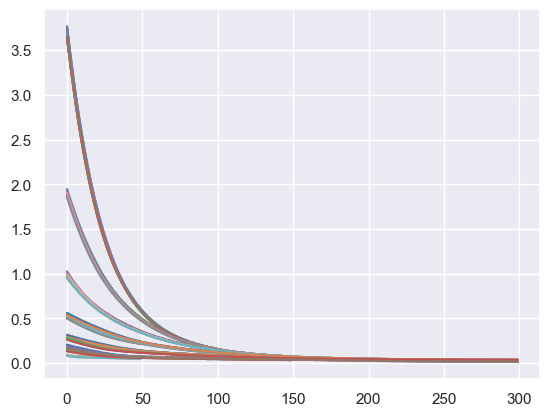

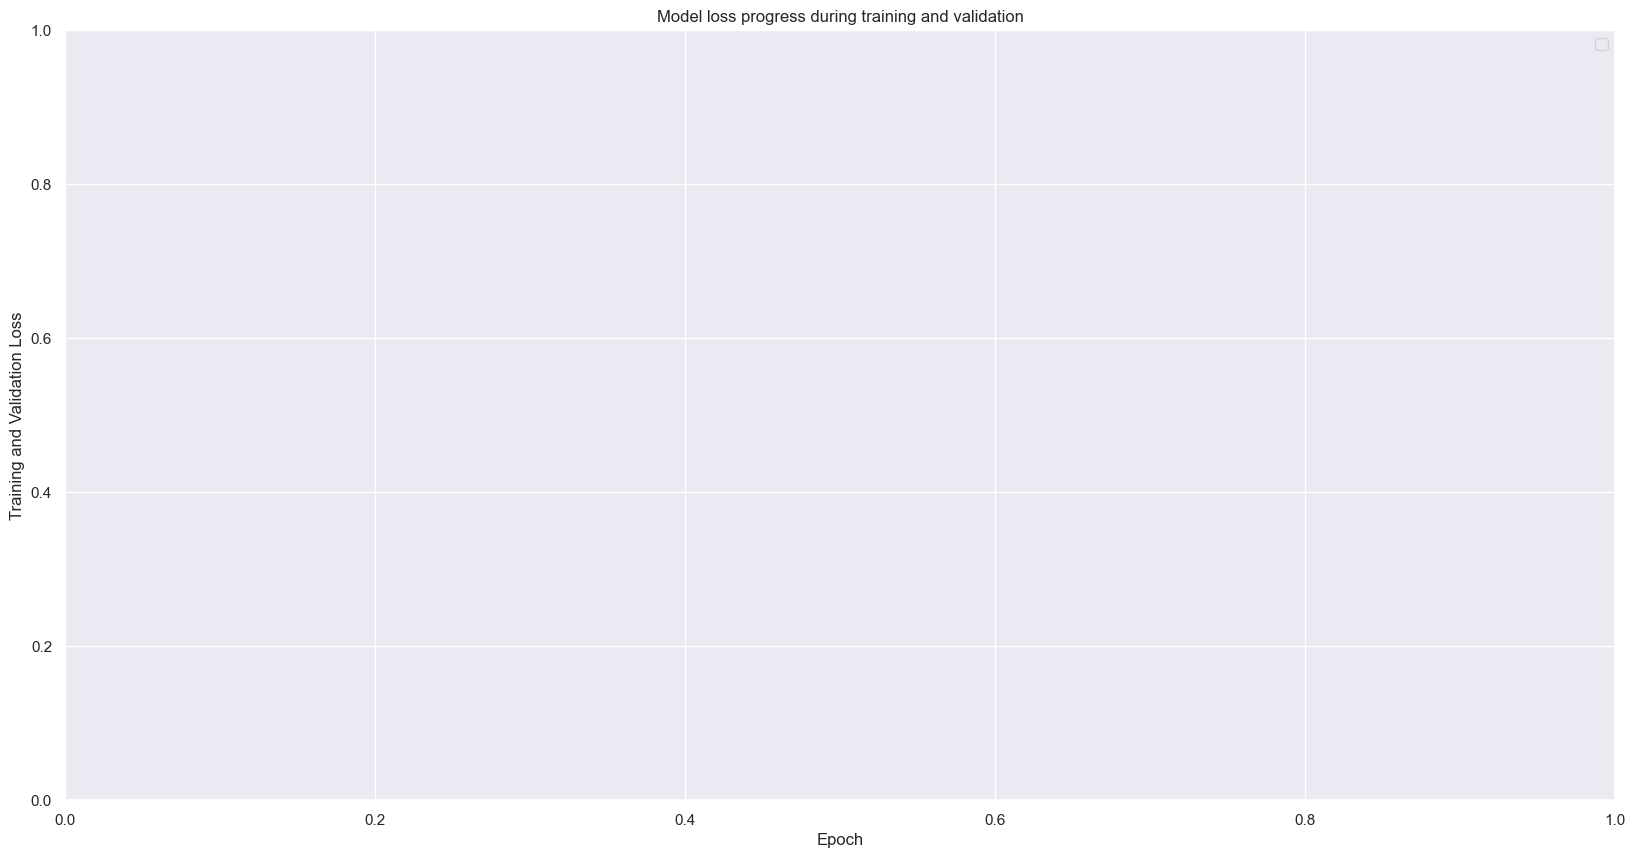

                                                    Train RMSE   Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...  100.749828  107.321835
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...  103.914959  107.988978
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers         98.988190  107.474271
50 epochs, [8, 8, 4, 4, 2, 2] layers                 99.966990  107.299954
50 epochs, [4, 4, 2, 2] layers                      101.333552  107.370527
50 epochs, [2, 2] layers                             48.372375   63.725381
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...   98.355006  107.750765
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...   99.111722  107.440157
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        98.312813  107.776966
100 epochs, [8, 8, 4, 4, 2, 2] layers                98.265295  107.807347
100 epochs, [4, 4, 2, 2] layers                      98.600044  107.790205
100 epochs, [2, 2] layers                            90.729848  100.574796
150 epochs, [64, 64, 32, 

In [17]:
# Initialize two separate scalers for normalization
scaler_rate = MinMaxScaler(feature_range=(0, 1))

# Fit and transform 'RATE' and 'during_covid' separately
rate_scaled = scaler_rate.fit_transform(agg_df[['Rate']])

# Concatenate the scaled data
dataset = np.concatenate([rate_scaled], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150, 300]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}  # store all rmse results
history_results = {}  # store history for all models

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')

    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(
            trainX, trainY, testX, testY, epochs, lstm_layers)

        # Add the history to history_results
        history_results[f'{epochs} epochs, {lstm_layers} layers'] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss']
        }

        # Add the loss for this model to the plot
        plt.plot(
            history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(
            history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler_rate.inverse_transform(trainPredict)
        trainY_orig = scaler_rate.inverse_transform([trainY])
        testPredict = scaler_rate.inverse_transform(testPredict)
        testY_orig = scaler_rate.inverse_transform([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:, 0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:, 0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {
            'Train RMSE': trainScore, 'Test RMSE': testScore}

# Plotting
for key, val in history_results.items():
    plt.plot(val['loss'], label=f'{key} - Train Loss')
    plt.plot(val['val_loss'], label=f'{key} - Validation Loss')

# Configure and show the plot
plt.figure(figsize=(20, 10))
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.show()

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


In [18]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_166 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_166 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_167 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_167 (Dropout)       (None, 2)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


<h4>Forecast the results</h4>

In [19]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100


def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)
        input_values_scaled = scaler.transform(last_values_2d)
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        prediction = model.predict(input_values_scaled)
        prediction = scaler.inverse_transform(prediction)
        forecast.append(prediction[0][0])
        last_values.append(prediction[0][0])

    return forecast


In [20]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(
    model, look_back, scaler_rate, last_values, weeks)
forecasted_dates = pd.date_range(
    start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()


1/1 [==============================] - 0s 20ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


,POD,RATE
0,2023-03-05,205.809998
1,2023-03-12,203.850006
2,2023-03-19,214.389999
3,2023-03-26,208.860001
4,2023-04-02,220.080002


,POD,RATE
7,2023-04-23,194.039993
8,2023-04-30,191.020004
9,2023-05-07,188.660004
10,2023-05-14,180.660004
11,2023-05-21,180.279999


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [21]:
comparison_df = pd.DataFrame(
    columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (
        new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(
    subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_10676\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({


,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-03-05,2023-03-12,2023-03-08,205.809998,260.0,79.157691
1,2023-03-12,2023-03-19,2023-03-15,203.850006,260.0,78.403849
2,2023-03-19,2023-03-26,2023-03-19,214.389999,300.0,71.463333
3,2023-03-26,2023-04-02,2023-03-26,208.860001,260.0,80.330769
4,2023-03-26,2023-04-02,2023-04-01,208.860001,260.0,80.330769
5,2023-04-02,2023-04-09,2023-04-08,220.080002,260.0,84.646155
6,2023-04-09,2023-04-16,2023-04-12,192.009995,300.0,64.003332
7,2023-04-09,2023-04-16,2023-04-15,192.009995,260.0,73.849998
8,2023-04-16,2023-04-23,2023-04-20,192.759995,260.0,74.138459
9,2023-04-23,2023-04-30,2023-04-26,194.039993,300.0,64.679998


The mean accuracy is 73.60%



<h4>Visualise all, Conclusion</h4>

<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date (Year Month)')

Text(0, 0.5, 'Cost Rate (USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

(17532.0, 19723.0)

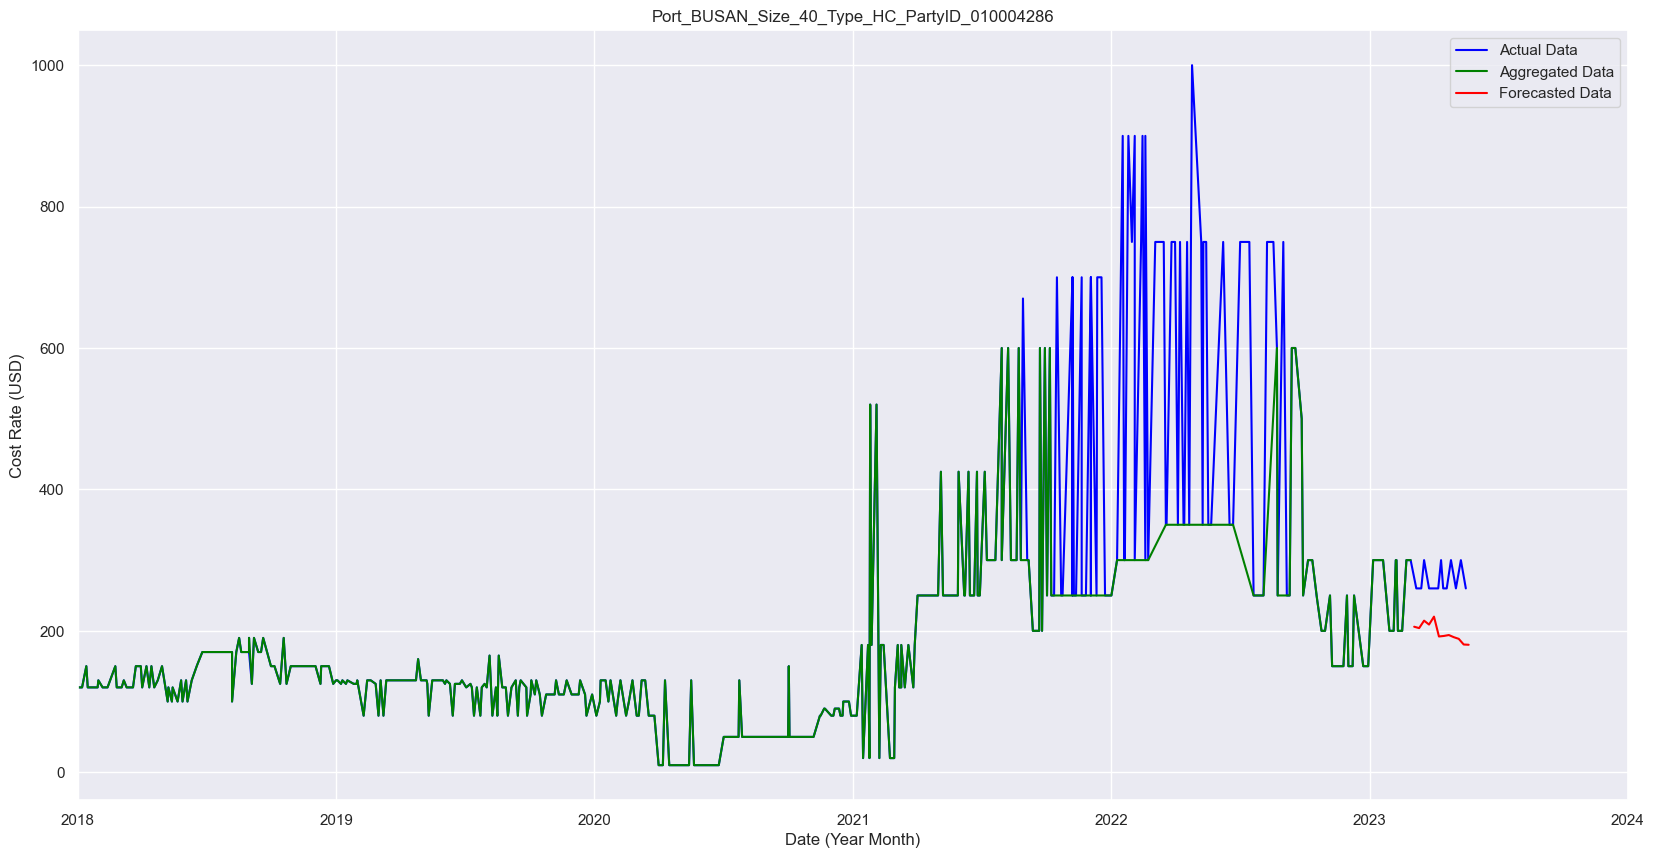

In [22]:
from matplotlib.dates import datestr2num

# Define the start and end dates of the desired range
start_date = '2018-01-01'
end_date = '2024-01-01'

# Convert the date strings to numeric values
start_num = datestr2num(start_date)
end_num = datestr2num(end_date)

# Concatenate sel_df and new_dates_df
merged_df = pd.concat([sel_df, new_dates_df])

# Sort the merged data by 'POD'
merged_df.sort_values('POD', inplace=True)

# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(merged_df['POD'], merged_df['RATE'], color='blue', label="Actual Data")
plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date (Year Month)')
plt.ylabel('Cost Rate (USD)')
plt.title(sel_country)
plt.legend()

# Set the x-axis limits using the converted numeric values
plt.xlim(start_num, end_num)
plt.show()